# **PRÁCTICA 3: GANs - Parte 1: GANs simples**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos


## Prelaboratorio:


- Lee y ejecuta el siguiente código. Simplificación de:
https://medium.com/@mattiaspinelli/simple-generative-adversarial-network-gans-with-keras-1fe578e44a87

## Laboratorio

### Explicación 

**Redes generativas antagónicas (GAN).**

<p align="justify">En pocas palabras, un GAN se compone de dos modelos separados, representados por redes neuronales: un generador G y un discriminador D. El objetivo del discriminador es saber si una muestra de datos proviene de una distribución de datos real, o si en su lugar se genera por G.</p>

<p align="justify">El objetivo del generador es generar muestras de datos para engañar al discriminador.</p>

<p align="justify">El generador no es más que una red neuronal profunda. Toma como entrada un vector de ruido aleatorio (generalmente gaussiano o de una distribución uniforme) y genera una muestra de datos de la distribución que queremos capturar.</p>

<p align="justify">
El discriminador es, nuevamente, solo una red neuronal. Su objetivo es, como su nombre indica, discriminar entre muestras reales y falsas. En consecuencia, su entrada es una muestra de datos, ya sea proveniente del generador o de la distribución de datos real.</p>

<p align="justify">La salida es un número simple, que representa la probabilidad de que la entrada sea real. Una probabilidad alta significa que el discriminador está seguro de que las muestras que le están dando son genuinas. Por el contrario, una probabilidad baja muestra una alta confianza en el hecho de que la muestra proviene de la red de generadores.</p>



### Importamos

<p align="justify">Por lo tanto, el objetivo es entrenar una NN para generar nuevas imágenes, que sean indistinguibles de las contenidas en la base de datos (MNIST en este caso) sin hacer copias idénticas. El NN aprende cuál es la "esencia" de la imagen y luego puede crearla a partir de una matriz aleatoria de números. La idea principal es tener dos redes neuronales separadas, un generador y un discriminador, encerrados en una competencia entre sí.</p>

Comenzamos entonces importando las librerías

In [ ]:
import os
import numpy as np

from IPython.core.debugger import Tracer

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
plt.switch_backend('agg') # allows code to run without a system DISPLAY


Leemos datos MNIST

In [ ]:
# Datos
(X_train, _), (_, _) = mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


### Modelo

#### Diseñamos modelo

Primero creamos instancias del generador y el discriminador (Dimensiones y optimizador)

In [ ]:
width=28
height=28
channels=1

in_shape = X_train.shape
in_shape = in_shape[1:]
OPTIMZADOR_ADAM = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Creamos el modelo del Generador, como podemos observar, esto es lo más simple posible, 4 capas completamente conectadas, con normalización por lotes. 

<p align="justify">El generador crea nuevas imágenes tan similares como sea posible a las imágenes en la base de datos.</p>

In [ ]:
model_gen = Sequential()
model_gen.add(Dense(256, input_shape=(100,)))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(512))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(1024))
model_gen.add(LeakyReLU(alpha=0.2))
model_gen.add(BatchNormalization(momentum=0.8))
model_gen.add(Dense(np.prod(in_shape), activation='tanh'))
model_gen.add(Reshape(in_shape))

model_gen.summary()
model_gen.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

<p align="justify">Creamos el modelo del discriminador que como podemos observar es igual de simple que el del generador. El discriminador trata de entender si son imágenes originales o sintéticas.</p>

In [ ]:
model_Disc = Sequential()
model_Disc.add(Flatten(input_shape=in_shape))
model_Disc.add(Dense(128, input_shape=in_shape))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(64))
model_Disc.add(LeakyReLU(alpha=0.2))
model_Disc.add(Dense(1, activation='sigmoid'))
model_Disc.summary()
model_Disc.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 108,801
Trainable params: 108,801
Non-tr

 <p align="justify">Ahora la parte difícil de entender. Vamos a crear el modelo combinado (model_gan en el código), este es solo un generador seguido de un discriminador. Tenga en cuenta que los pesos del discriminador se han congelado, por lo que cuando entrene este modelo, las capas del generador no se verán afectadas y solo transmitirán hacia arriba el gradiente.</p>



In [ ]:
model_gan = Sequential()
model_gan.add(model_gen)
model_gan.add(model_Disc)
model_gan.compile(loss='binary_crossentropy', optimizer=OPTIMZADOR_ADAM)

model_gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         1493520   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 108801    
                                                                 
Total params: 1,602,321
Trainable params: 1,598,737
Non-trainable params: 3,584
_________________________________________________________________


### Entrenamiento

In [ ]:
# Parámetros del entrenamiento
epochs = 5000
batch = 10

# Bucle entrenamiento

DD_loss = np.zeros((epochs,))
GG_loss = np.zeros((epochs,))

for cnt in range(epochs):

    ## Entrenamos discriminador
        # Imágenes reales
    random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
    legit_images = X_train[random_index : random_index + np.int64(batch/2)].reshape((np.int64(batch/2),)+in_shape)
        # Imágenes sintéticas
    gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
    syntetic_images = model_gen.predict(gen_noise)
        # Combinamos imágenes reales y sintéticas
    x_combined_batch = np.concatenate((legit_images, syntetic_images))
    y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))
        # Entrenamos discriminador
    d_loss = model_Disc.train_on_batch(x_combined_batch, y_combined_batch)


    ## Entrenamos generador
        # Imágenes sintéticas
    noise = np.random.normal(0, 1, (batch, 100))
    y_mislabled = np.ones((batch, 1))
        # Entremaos generador
    g_loss = model_gan.train_on_batch(noise, y_mislabled)

    ## Evolución entrenamiento
    print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

    DD_loss[cnt] = d_loss[0]
    GG_loss[cnt] = g_loss
    

epoch: 0, [Discriminator :: d_loss: 0.928271], [ Generator :: loss: 0.809880]
epoch: 1, [Discriminator :: d_loss: 0.750845], [ Generator :: loss: 0.746037]
epoch: 2, [Discriminator :: d_loss: 0.487109], [ Generator :: loss: 0.709891]
epoch: 3, [Discriminator :: d_loss: 0.499021], [ Generator :: loss: 0.580878]
epoch: 4, [Discriminator :: d_loss: 0.526355], [ Generator :: loss: 0.469075]
epoch: 5, [Discriminator :: d_loss: 0.426222], [ Generator :: loss: 0.533293]
epoch: 6, [Discriminator :: d_loss: 0.547403], [ Generator :: loss: 0.552337]
epoch: 7, [Discriminator :: d_loss: 0.607228], [ Generator :: loss: 0.410859]
epoch: 8, [Discriminator :: d_loss: 0.679411], [ Generator :: loss: 0.456753]
epoch: 9, [Discriminator :: d_loss: 0.521559], [ Generator :: loss: 0.411731]
epoch: 10, [Discriminator :: d_loss: 0.630109], [ Generator :: loss: 0.417659]
epoch: 11, [Discriminator :: d_loss: 0.716812], [ Generator :: loss: 0.409863]
epoch: 12, [Discriminator :: d_loss: 0.744121], [ Generator ::

Curvas de aprendizaje

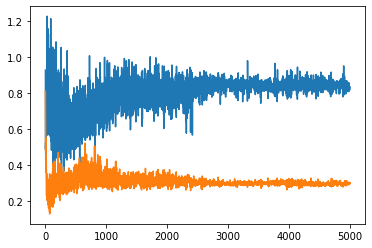

In [ ]:
% matplotlib inline 
plt.figure
plt.plot(DD_loss)
plt.plot(GG_loss)

### Generar datos

In [ ]:
# Generamos imagen sintética
gen_noise = np.random.normal(0, 1, (np.int64(10), 100))
syntetic_images = model_gen.predict(gen_noise)

(-0.5, 27.5, 27.5, -0.5)

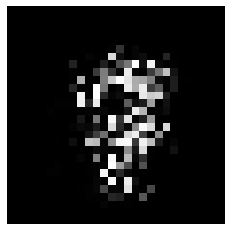

In [ ]:
# Mostramos imagen sintética
plt.imshow(syntetic_images[5,:,:,0],cmap='gray')
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

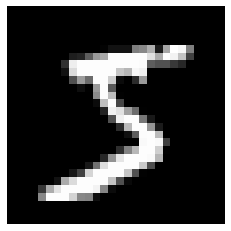

In [ ]:
# Esto es una imagen real (por comparar)
plt.imshow(X_train[0,:,:,0],cmap='gray')
plt.axis('off')